## TP n° 1 : Manipulation de données audio : classification stylistique


### - Partie 1 : Manipulation de fichiers audio

In [15]:
!pip install playsound
!pip install matplotlib
!pip install seaborn
!pip install librosa

Audio time series: [1.0904326e-03 1.3623741e-03 1.4456341e-03 ... 4.1513053e-06 4.0163877e-06
 3.6187041e-06];
Number of samples: 11819689;
Sample rate: 44100;

Calculated audio duration: 268.0202 seconds;
Expected duration: 268 seconds.


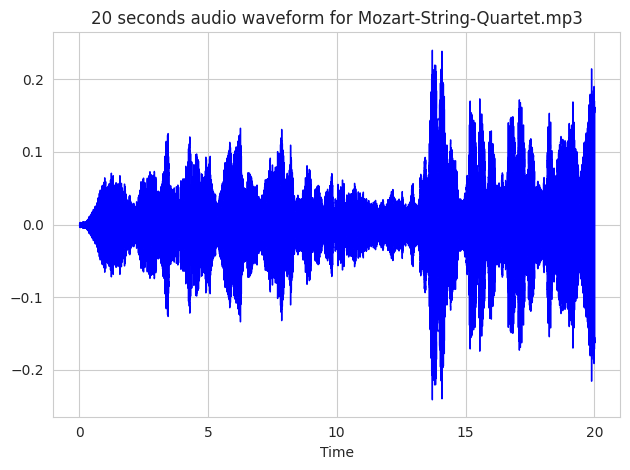

In [16]:
from playsound import playsound
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load
from librosa.display import waveshow, specshow


audio_path = './audio/classique/Mozart-String-Quartet.mp3'

# playsound(audio_path)

audio_data, sample_rate = load(audio_path, sr=None)
print(f"Audio time series: {audio_data};\nNumber of samples: {len(audio_data)};\nSample rate: {sample_rate};\n")

audio_length = len(audio_data) / sample_rate
print(f"Calculated audio duration: {audio_length:.4f} seconds;\nExpected duration: 268 seconds.")

# Load the first 20 seconds of the audio
short_audio_data, short_sample_rate = load(audio_path, duration=20.0, sr=None)
sns.set_style("whitegrid")


waveshow(short_audio_data, sr=short_sample_rate, max_points=4000, color='b')
plt.title(f"20 seconds audio waveform for {audio_path.split('/')[-1]}")
plt.tight_layout()

### - Partie 2 : Représentation MFCCs

MFCC matrix: [[-6.3108276e+02 -6.2340741e+02 -6.2859424e+02 ... -4.2355289e+02
  -4.1231015e+02 -4.0191470e+02]
 [ 9.0284470e+01  7.9042953e+01  7.0759697e+01 ...  2.1299614e+02
   2.1250070e+02  2.0048016e+02]
 [ 2.1121704e+01  6.2669029e+00  3.9824321e+00 ... -1.7736706e+01
  -2.0703897e+01 -1.3364901e+01]
 ...
 [ 5.2292500e+00  1.9074188e+01  2.9117142e+01 ... -4.4705477e+00
  -5.2679420e+00 -5.8305111e+00]
 [ 7.9767876e+00  1.3579590e+01  1.9681330e+01 ...  4.2926445e+00
   2.1332188e+00  1.1907628e-01]
 [ 7.1455927e+00  9.1086006e-01  2.9571569e+00 ... -3.4895406e+00
  -5.8292809e+00 -1.3436276e+00]], shape: (12, 862)
86.2 values per second.
One value in MFCC for one coefficient corresponds to 511.6009280742459 samples.


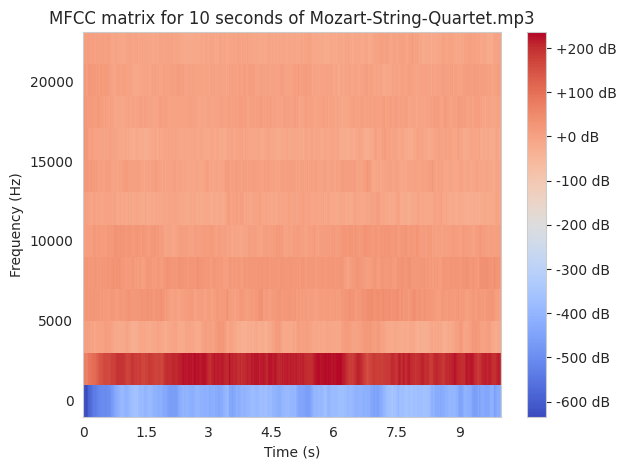

In [17]:
from librosa.feature import mfcc

n_bande_freq = 12
duration_ = 10

ts, sr = load(audio_path, duration=duration_, sr=None)

mfcc_ = mfcc(y=ts, sr=sr, n_mfcc=n_bande_freq)
print(f"MFCC matrix: {mfcc_}, shape: {mfcc_.shape}")

values_per_second = mfcc_.shape[1] / duration_
print(f"{values_per_second} values per second.")

samples_per_value = sr / values_per_second
print(f"One value in MFCC for one coefficient corresponds to {samples_per_value} samples.")

specshow(mfcc_, sr=sr, x_axis='time', y_axis='hz')
plt.title(f"MFCC matrix for {duration_} seconds of {audio_path.split('/')[-1]}")
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### - Partie 3 : Préparation des descripteurs

In [18]:
import numpy as np

mfcc_ = mfcc_.T

print("Shape of mfccs:", mfcc_.shape)

Shape of mfccs: (862, 12)


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

norm_mfcc = scaler.fit_transform(mfcc_)

print(f"Mean on first dimension: {norm_mfcc.mean(axis=0)}")
print()
print(f"Std on first dimension: {norm_mfcc.std(axis=0)}")

Mean on first dimension: [ 0.0000000e+00 -1.7701611e-08  1.3276209e-08  1.7701611e-08
  2.2127014e-09 -8.8508054e-09 -2.6552417e-08  0.0000000e+00
 -1.1063507e-08 -1.1063507e-08 -1.3276209e-08  0.0000000e+00]

Std on first dimension: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


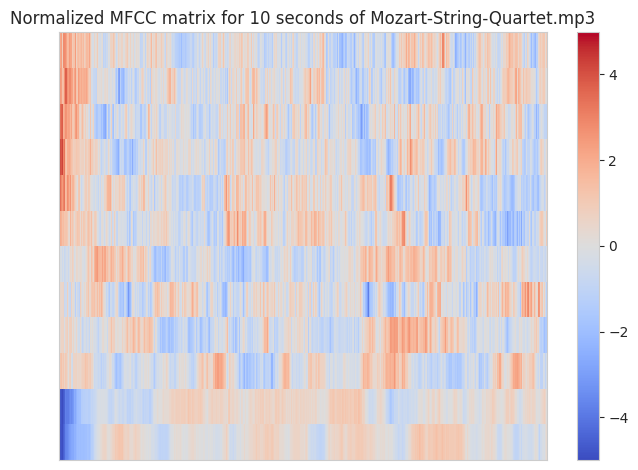

In [20]:
# Display the normalized MFCC matrix
specshow(norm_mfcc.T, sr=sr)  # Transpose back for visualization
plt.title(f"Normalized MFCC matrix for {duration_} seconds of {audio_path.split('/')[-1]}")
plt.colorbar()
plt.tight_layout()
plt.show()

### - Partie 4 : Entraînement d'un modèle

In [21]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load, feature

seed = 2024
np.random.seed(seed)


n_desc = 128 #@param
duration = 20 #@param
fnames = ["./audio/classique/Mozart-String-Quartet.mp3", "./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3"] #@param

# Load and preprocess audio files
ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=duration)
ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=duration)

mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=12).T)
rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=12).T)

X = np.concatenate((mozart_mfcc, rodrigo_mfcc))
y = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

# shuffle the dataset
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

print(f"X shape: {X.shape}; y shape: {y.shape}")
print(f"Features: {X[:1]}")
print(f"Labels: {y[:1]}")

X shape: (1724, 12); y shape: (1724,)
Features: [[ 0.39277598  0.36502534  0.44862634  2.3783073   0.8575182  -0.9464653
  -1.1272899   1.1233402   0.13973309  1.2290354   0.29027024 -0.10939813]]
Labels: [0]


In [22]:
svm_clf = SVC(C=1.0, kernel='rbf', random_state=seed)
svm_clf.fit(X, y)

SVC(random_state=2024)

### - Partie 5 : Évaluation d'un modèle

In [23]:
val_duration = 5 #@param


ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=val_duration, offset=duration)
ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=val_duration, offset=duration)

mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=12).T)
rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=12).T)

X_val = np.concatenate((mozart_mfcc, rodrigo_mfcc))
y_val = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]

print(f"X_val shape: {X_val.shape}; y shape: {y_val.shape}")
print(f"Features: {X_val[:1]}")
print(f"Labels: {y_val[:1]}")

X_val shape: (432, 12); y shape: (432,)
Features: [[ 2.4969769  -1.0039884  -0.8534486   0.09738483  0.911167    1.1749331
  -1.7620907  -0.8806637  -1.326076   -1.13626     1.869024    1.3712916 ]]
Labels: [0]


The percentage of correct predictions: 73.380%
recall_score: 0.866
precision_score: 0.685
Support Vector Machine Classifier:
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       216
           1       0.68      0.87      0.76       216

    accuracy                           0.73       432
   macro avg       0.75      0.73      0.73       432
weighted avg       0.75      0.73      0.73       432



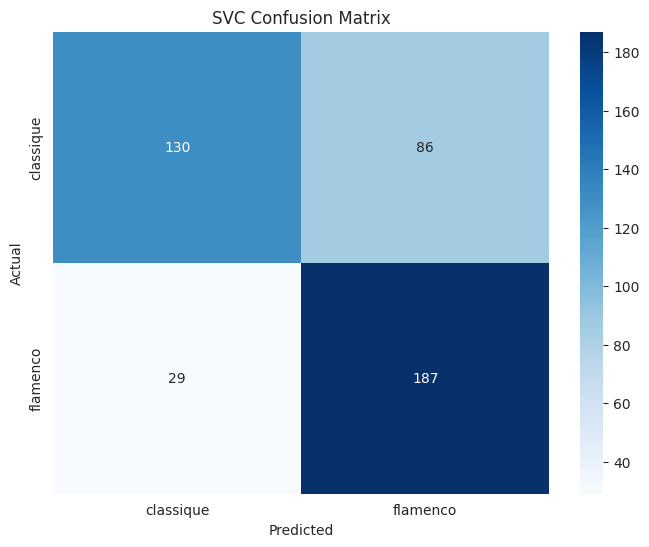

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, accuracy_score

def plot_confusion_matrix(cm: np.ndarray, title: str):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['classique', 'flamenco'], yticklabels=['classique', 'flamenco'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Predict
y_pred_svc = svm_clf.predict(X_val)
eval_svc = classification_report(y_val, y_pred_svc)
cm_svc = confusion_matrix(y_val, y_pred_svc)

print(f"The percentage of correct predictions: {accuracy_score(y_val, y_pred_svc)*100:.3f}%")
print(f"recall_score: {recall_score(y_val, y_pred_svc):.3f}")
print(f"precision_score: {precision_score(y_val, y_pred_svc):.3f}")
print(f"Support Vector Machine Classifier:\n{eval_svc}")
plot_confusion_matrix(cm_svc, "SVC Confusion Matrix")

### - Partie 6 : Expériences

##### MFCC coef search

The best accuracy value obtained for n_mfcc set to 16


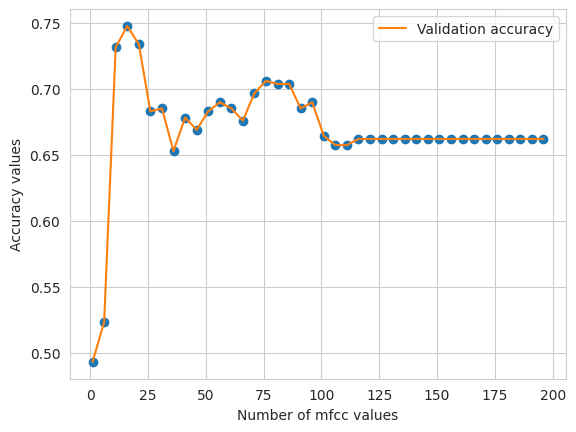

In [25]:
def run_pipeline(mfcc_coef : int) -> float:
    # Load and preprocess audio files
    ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=duration)
    ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=duration)

    mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=mfcc_coef).T)
    rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=mfcc_coef).T)

    X = np.concatenate((mozart_mfcc, rodrigo_mfcc))
    y = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

    # shuffle the dataset
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    svm_clf = SVC(C=1.0, kernel='rbf', random_state=seed)
    svm_clf.fit(X, y)
    
    val_duration = 5 #@param

    ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=val_duration, offset=duration)
    ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=val_duration, offset=duration)

    mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=mfcc_coef).T)
    rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=mfcc_coef).T)

    X_val = np.concatenate((mozart_mfcc, rodrigo_mfcc))
    y_val = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

    idx = np.random.permutation(len(X_val))
    X_val, y_val = X_val[idx], y_val[idx]

    # Predict
    y_pred_svc = svm_clf.predict(X_val)
    valid_accuracy = accuracy_score(y_val, y_pred_svc)

    return valid_accuracy

mfcc_coefs = np.arange(1, 200, step=5)
valid_accuracies = []
for mfcc_coef in mfcc_coefs:
    valid_acc = run_pipeline(mfcc_coef)
    valid_accuracies.append(valid_acc)

plt.plot(mfcc_coefs, valid_accuracies, 'o')
plt.plot(mfcc_coefs, valid_accuracies, label="Validation accuracy")
plt.xlabel("Number of mfcc values")
plt.ylabel("Accuracy values")
plt.legend()

print(f"The best accuracy value obtained for n_mfcc set to {mfcc_coefs[np.argmax(valid_accuracies)]}")

/tmp/ipykernel_24351/3762994875.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=val_duration, offset=duration)
/home/user/miniconda3/envs/music/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/home/user/miniconda3/envs/music/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Text(0, 0.5, 'Accuracy values')

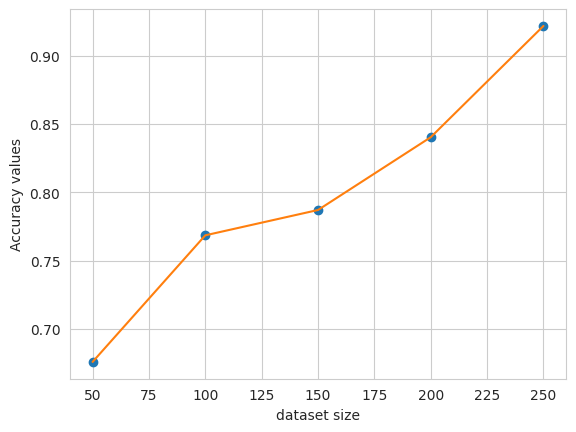

In [31]:
def run_pipeline(duration : int) -> float:
    # Load and preprocess audio files
    ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=duration)
    ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=duration)

    mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=16).T)
    rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=16).T)

    X = np.concatenate((mozart_mfcc, rodrigo_mfcc))
    y = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

    # shuffle the dataset
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    svm_clf = SVC(C=1.0, kernel='rbf', random_state=seed)
    svm_clf.fit(X, y)
    
    val_duration = 5 #@param

    ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=val_duration, offset=duration)
    ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=val_duration, offset=duration)

    mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=16).T)
    rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=16).T)

    X_val = np.concatenate((mozart_mfcc, rodrigo_mfcc))
    y_val = np.array([0 for _ in range(mozart_mfcc.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0])])

    idx = np.random.permutation(len(X_val))
    X_val, y_val = X_val[idx], y_val[idx]

    # Predict
    y_pred_svc = svm_clf.predict(X_val)
    valid_accuracy = accuracy_score(y_val, y_pred_svc)

    return valid_accuracy

sizes = [i for i in range(50, 300, 50)]
valid_accuracies = []
for size in sizes:
    valid_acc = run_pipeline(size)
    valid_accuracies.append(valid_acc)

plt.plot(sizes, valid_accuracies, 'o')
plt.plot(sizes, valid_accuracies)
plt.xlabel("dataset size")
plt.ylabel("Accuracy values")

The percentage of correct predictions: 83.179%
Support Vector Machine Classifier:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       432
           1       0.82      0.94      0.87       432
           2       0.80      0.80      0.80       432

    accuracy                           0.83      1296
   macro avg       0.83      0.83      0.83      1296
weighted avg       0.83      0.83      0.83      1296



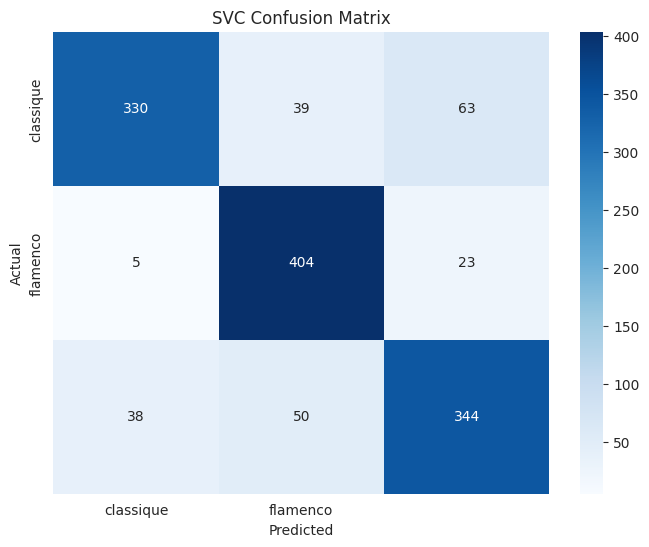

In [34]:
duration = 100 #@param

# Load and preprocess audio files
ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=duration)
ts_mozart1, sr_mozart1 = load('audio/classique/Haydn-String-Quartet.mp3', duration=duration)
ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=duration)
ts_rodrigo1, sr_rodrigo1 = load('audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3', duration=duration)
ts_punk, sr_punk = load('audio/punk/Millencolin-No_Cigar.mp3', duration=duration)
ts_punk1, sr_punk1 = load('audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3', duration=duration)

mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=mfcc_coef).T)
mozart_mfcc1 = scaler.fit_transform(mfcc(y=ts_mozart1, sr=sr_mozart1, n_mfcc=mfcc_coef).T)
rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=mfcc_coef).T)
rodrigo_mfcc1 = scaler.fit_transform(mfcc(y=ts_rodrigo1, sr=sr_rodrigo1, n_mfcc=mfcc_coef).T)
punk_mfcc = scaler.fit_transform(mfcc(y=ts_punk, sr=sr_punk, n_mfcc=mfcc_coef).T)
punk_mfcc1 = scaler.fit_transform(mfcc(y=ts_punk1, sr=sr_punk1, n_mfcc=mfcc_coef).T)

X = np.concatenate((mozart_mfcc, mozart_mfcc1, rodrigo_mfcc, rodrigo_mfcc1, punk_mfcc, punk_mfcc1))
y = np.array([0 for _ in range(mozart_mfcc.shape[0]+mozart_mfcc1.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0]+rodrigo_mfcc1.shape[0])] + [2 for _ in range(punk_mfcc.shape[0]+punk_mfcc1.shape[0])])

# shuffle the dataset
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

svm_clf = SVC(C=1.0, kernel='rbf', random_state=seed)
svm_clf.fit(X, y)

val_duration = 5 #@param

ts_mozart, sr_mozart = load('./audio/classique/Mozart-String-Quartet.mp3', duration=val_duration, offset=duration)
ts_mozart1, sr_mozart1 = load('audio/classique/Haydn-String-Quartet.mp3', duration=val_duration, offset=duration+val_duration)
ts_rodrigo, sr_rodrigo = load('./audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3', duration=val_duration, offset=duration)
ts_rodrigo1, sr_rodrigo1 = load('audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3', duration=val_duration, offset=duration+val_duration)
ts_punk, sr_punk = load('audio/punk/Millencolin-No_Cigar.mp3', duration=val_duration)
ts_punk1, sr_punk1 = load('audio/punk/The-Offspring-The-Kids-Arent-Alright.mp3', duration=val_duration)

mozart_mfcc = scaler.fit_transform(mfcc(y=ts_mozart, sr=sr_mozart, n_mfcc=mfcc_coef).T)
mozart_mfcc1 = scaler.fit_transform(mfcc(y=ts_mozart1, sr=sr_mozart1, n_mfcc=mfcc_coef).T)
rodrigo_mfcc = scaler.fit_transform(mfcc(y=ts_rodrigo, sr=sr_rodrigo, n_mfcc=mfcc_coef).T)
rodrigo_mfcc1 = scaler.fit_transform(mfcc(y=ts_rodrigo1, sr=sr_rodrigo1, n_mfcc=mfcc_coef).T)
punk_mfcc = scaler.fit_transform(mfcc(y=ts_punk, sr=sr_punk, n_mfcc=mfcc_coef).T)
punk_mfcc1 = scaler.fit_transform(mfcc(y=ts_punk1, sr=sr_punk1, n_mfcc=mfcc_coef).T)

X_val = np.concatenate((mozart_mfcc, mozart_mfcc1, rodrigo_mfcc, rodrigo_mfcc1, punk_mfcc, punk_mfcc1))
y_val = np.array([0 for _ in range(mozart_mfcc.shape[0]+mozart_mfcc1.shape[0])] + [1 for _ in range(rodrigo_mfcc.shape[0]+rodrigo_mfcc1.shape[0])] + [2 for _ in range(punk_mfcc.shape[0]+punk_mfcc1.shape[0])])

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]

# Predict
y_pred_svc = svm_clf.predict(X_val)
eval_svc = classification_report(y_val, y_pred_svc)
cm_svc = confusion_matrix(y_val, y_pred_svc)

print(f"The percentage of correct predictions: {accuracy_score(y_val, y_pred_svc)*100:.3f}%")
print(f"Support Vector Machine Classifier:\n{eval_svc}")
plot_confusion_matrix(cm_svc, "SVC Confusion Matrix")